In [1]:
import copy
import random

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.transforms.functional as F
import torch.nn.functional as F1
from torchsummary import summary
from u_net import UNet


if torch.backends.mps.is_available():
    device = torch.device("mps")  # GPU на Mac (Apple Silicon або AMD)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA GPU (не на Mac)
    print(
        f"GPU count: {torch.cuda.device_count()}"
        f", CUDA version: {torch.version.cuda}"
        f", cuDNN version: {torch.backends.cudnn.version()}"
    )
else:
    device = torch.device("cpu")  # fallback

print("Using GPU:", device)

Using GPU: cpu


In [7]:
def random_color_jitter(img):
    brightness = random.uniform(0.8, 1.2)
    contrast = random.uniform(0.8, 1.2)
    saturation = random.uniform(0.8, 1.2)
    hue = random.uniform(-0.1, 0.1)

    img = F.adjust_brightness(img, brightness)
    img = F.adjust_contrast(img, contrast)
    img= F.adjust_saturation(img, saturation)
    img = F.adjust_hue(img, hue)
    return img


class SegmentationTransformation:
    def __init__(self, size=(256, 256)):
        self.size = size

    def __call__(self, img, mask):
        if random.random() < 0.5:
            img = F.hflip(img)
            mask = F.hflip(mask)

        img = F.pad(img, padding=[8])
        mask = F.pad(mask, padding=[8])


        i, j, h ,w = transforms.RandomCrop.get_params(img, (min(img.height, 256), min(img.width, 256)))
        img = F.crop(img, i, j ,h , w)
        mask = F.crop(mask, i, j, h, w)

        img = random_color_jitter(img)

        img = F.resize(img, size=self.size, interpolation=transforms.InterpolationMode.BILINEAR)
        mask = F.resize(mask, size=self.size, interpolation=transforms.InterpolationMode.NEAREST)

        img = F.to_tensor(img)
        img = F.normalize(img, [0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
        mask = F.pil_to_tensor(mask)

        return img, mask

class SegmentationTestTransformation:
    def __init__(self, size=(256, 256)):
        self.size = size

    def __call__(self, img, mask):
        img = F.resize(img, self.size, interpolation=torchvision.transforms.InterpolationMode.BILINEAR)
        mask = F.resize(mask, self.size, interpolation=torchvision.transforms.InterpolationMode.NEAREST)

        img = F.to_tensor(img)
        img = F.normalize(img, [0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
        mask = F.pil_to_tensor(mask)

        return img, mask

In [8]:
batch_size = 32
num_workers = 0
num_classes = 21
epochs = 15
lr=1e-3
weight_decay = 1e-4
pin_memory = True if(torch.cuda.is_available()) else False
alpha = 0.7
beta = 0.3
patience = 5

In [37]:
# class BCEDiceLoss(nn.Module):
#     def __init__(self, weights=None):
#         super(BCEDiceLoss, self).__init__()
#
#     def forward(self, inputs, targets, smooth = 0.001):
#
#         inputs = F1.sigmoid(inputs)
#
#         inputs = inputs.contiguous().view(-1)
#         targets = targets.contiguous.view(-1)
#
#         intersection = (inputs*targets).sum()
#         dice_loss = (1 - ((2. * intersection + smooth)/ (inputs.sum() + targets.sum() + smooth)))
#         BCE = F1.binary_cross_entropy(inputs, targets, weight=None, size_average=True, reduction='mean')
#
#         return alpha * dice_loss + beta * BCE

In [9]:
def dice_coefficient(pred, target, num_classes=num_classes, smooth=1e-6, ignore_background = True):
    cls = 1 if ignore_background else 0
    dice = []
    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum()
        dice_cls = ((2. * intersection + smooth) / (union + smooth))
        dice.append(dice_cls)
    return torch.mean(torch.stack(dice)) if dice else torch.tensor(0.0)

def iou_score(pred, target, num_classes=num_classes, smooth=1e-6):
    iou = 0.0
    for cls in range(num_classes):
        pred_cls = (pred == cls).float()
        target_cls = (target == cls).float()
        intersection = (pred_cls * target_cls).sum()
        union = pred_cls.sum() + target_cls.sum() - intersection
        iou += ((2. * intersection + smooth) / (union + smooth))
    return iou/num_classes

def pixel_accuracy(pred, target):
    correct = (pred == target).sum().item()
    total_pixel_f = target.numel()
    return correct / total_pixel_f

In [10]:
def run_one_epoch(train_loader_f, device_f, model_f, criterion_f, optimizer_f):
    avg_loss, avg_dice, avg_iou, avg_acc = 0, 0, 0 ,0
    model_f.train()
    running_loss = 0.0
    total_dice, total_iou, total_acc = 0.0, 0.0, 0.0
    total_batches = len(train_loader_f)

    for images, targets in tqdm(train_loader_f):
        images, targets = images.to(device_f), targets.to(device_f)

        outputs_f = model_f(images)

        loss = criterion_f(outputs_f, targets)
        loss.backward()
        optimizer_f.step()
        optimizer_f.zero_grad()

        running_loss+=loss.item()

        preds = torch.argmax(outputs_f, dim=1)

        dice = dice_coefficient(preds, targets)
        iou = iou_score(preds, targets)
        acc = pixel_accuracy(preds, targets)

        total_dice += dice
        total_iou += iou
        total_acc += acc

        avg_loss = running_loss / total_batches
        avg_dice = total_dice / total_batches
        avg_iou = total_iou / total_batches
        avg_acc = total_acc / total_batches

    return avg_loss, avg_dice, avg_iou, avg_acc



def validate(test_loader_f, device_f, model_f, criterion_f):
    model_f.eval()
    running_loss = 0.0
    total_dice, total_iou, total_acc = 0.0, 0.0, 0.0
    total_batches = len(test_loader_f)
    with torch.no_grad():
        for images, targets in tqdm(test_loader_f):
            images, targets = images.to(device_f), targets.to(device_f)

            outputs_f = model_f(images)

            loss = criterion_f(outputs_f, targets)
            running_loss += loss.item()

            preds = torch.argmax(outputs_f, dim=1)

            dice = dice_coefficient(preds, targets)
            iou = iou_score(preds, targets)
            acc = pixel_accuracy(preds, targets)

            total_dice += dice
            total_iou += iou
            total_acc += acc

    # Середні значення по всіх батчах
    avg_loss = running_loss / total_batches
    avg_dice = total_dice / total_batches
    avg_iou = total_iou / total_batches
    avg_acc = total_acc / total_batches

    return avg_loss, avg_dice, avg_iou, avg_acc

In [11]:


train_dataset = torchvision.datasets.VOCSegmentation(root='./data', year='2012', image_set='train', download=False, transforms=SegmentationTransformation())

test_dataset = torchvision.datasets.VOCSegmentation(root='./data', year='2012', image_set='val', download=False, transforms=SegmentationTestTransformation())

In [12]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=pin_memory)


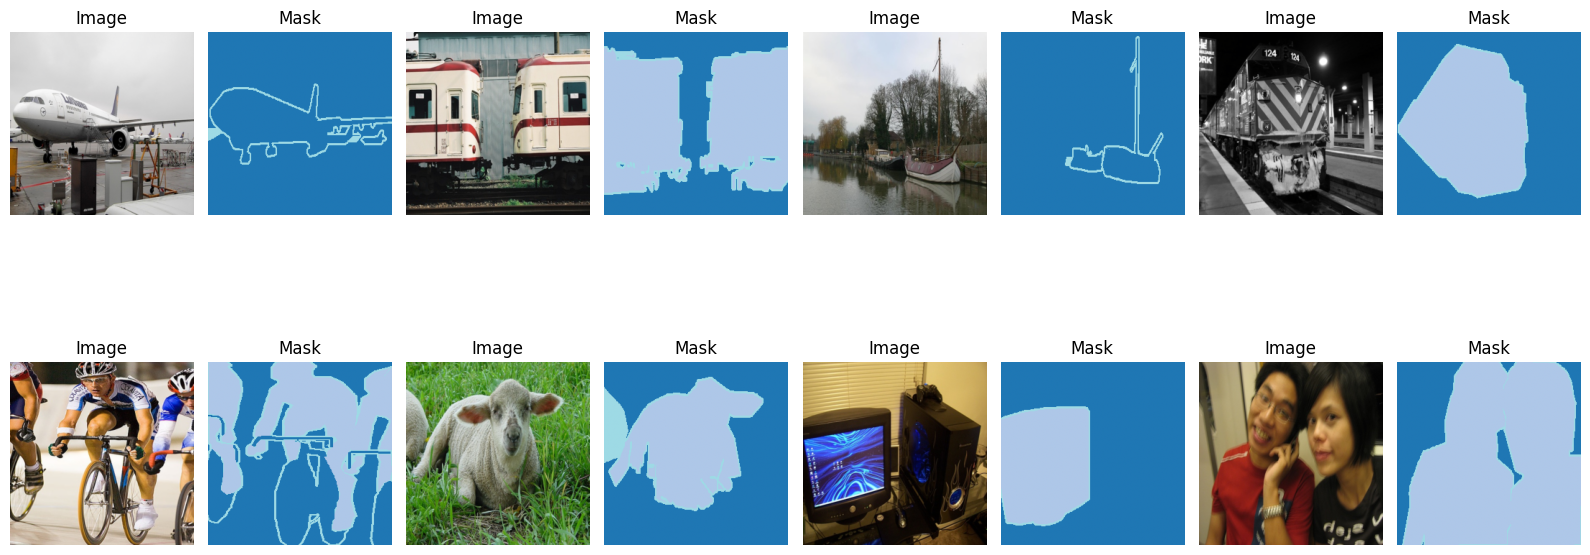

In [15]:
def show_batch_images_masks(images, masks, n=8, class_colors=None):
    n = min(n, images.size(0))
    cols = 4
    rows = (n + cols - 1) // cols
    plt.figure(figsize=(cols*4, rows*4))
    for i in range(n):
        # Відновлюємо картинку (denormalization)
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]
        img = img.clip(0, 1)

        mask = masks[i].cpu().numpy()
        if mask.ndim == 3 and mask.shape[0] == 1:  # виправлення
            mask = mask[0]

        plt.subplot(rows, cols*2, i*2 + 1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis('off')

        plt.subplot(rows, cols*2, i*2 + 2)
        if class_colors is not None:
            plt.imshow(mask, cmap=None, vmin=0, vmax=len(class_colors)-1)
        else:
            plt.imshow(mask, cmap='tab20')
        plt.title("Mask")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Візьмемо один батч
images, masks = next(iter(test_loader))

# Показуємо перші 8
show_batch_images_masks(images, masks, n=8)

In [ ]:

model = UNet(num_classes=num_classes).to(device)
summary(model, (3, 256, 256))

criterion =nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr, weight_decay=weight_decay)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

best_val_loss = float('inf')
best_model_state = copy.deepcopy(model.state_dict())
counter = 0

train_losses, val_losses = [], []
train_dices, val_dices = [], []
train_ious, val_ious = [], []
train_accs, val_accs = [], []

for epoch in tqdm(range(epochs)):
    train_loss, train_dice, train_iou, train_acc = run_one_epoch(train_loader, device, model, criterion, optimizer)
    val_loss, val_dice, val_iou, val_acc = validate(test_loader, device, model, criterion)
    scheduler.step(val_loss)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_dices.append(train_dice)
    val_dices.append(val_dice)
    train_ious.append(train_iou)
    val_ious.append(val_iou)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} "
      f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
      f"Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}, "
      f"Train IoU: {train_iou:.4f}, Val IoU: {val_iou:.4f}, "
      f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")

    if epoch % 5 == 0:
        imgs, masks = next(iter(test_loader))
        imgs, masks = imgs.to(device), masks.to(device)
        with torch.no_grad():
             preds = torch.argmax(model(imgs), dim=1)

        show_batch_images_masks(imgs.cpu(), preds.cpu(), n=4)

    if val_ious < best_val_loss:
        best_val_loss = val_ious
        best_model_state = copy.deepcopy(model.state_dict())
        counter = 0
    else:
        counter+=1
        if counter > 5:
            print('Early stop triggered')
            break

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
 DoubleConvolution-5         [-1, 64, 256, 256]               0
         MaxPool2d-6         [-1, 64, 128, 128]               0
        DownSample-7  [[-1, 64, 256, 256], [-1, 64, 128, 128]]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
              ReLU-9        [-1, 128, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]         147,584
             ReLU-11        [-1, 128, 128, 128]               0
DoubleConvolution-12        [-1, 128, 128, 128]               0
        MaxPool2d-13          [-1, 128, 64, 64]               0
       DownSample-14  [[

  0%|          | 0/46 [00:00<?, ?it/s]

In [ ]:
load_model = UNet(num_classes=num_classes)
load_model.load_state_dict(best_model_state)
load_model.eval()

val_loss, val_dice, val_iou, val_acc = validate(test_loader, device, model, criterion)

print(val_loss, val_dice, val_iou, val_acc)

In [12]:
def plot_metrics(train_values, val_values, title):
    plt.figure(figsize=(8,6))
    plt.plot(train_values, label='Train')
    plt.plot(val_values, label='Validation')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics(train_losses, val_losses, "Loss")
plot_metrics(train_dices, val_dices, "Dice Coefficient")
plot_metrics(train_ious, val_ious, "IoU")
plot_metrics(train_accs, val_accs, "Pixel Accuracy")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
              ReLU-2         [-1, 64, 256, 256]               0
            Conv2d-3         [-1, 64, 256, 256]          36,928
              ReLU-4         [-1, 64, 256, 256]               0
 DoubleConvolution-5         [-1, 64, 256, 256]               0
         MaxPool2d-6         [-1, 64, 128, 128]               0
        DownSample-7  [[-1, 64, 256, 256], [-1, 64, 128, 128]]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
              ReLU-9        [-1, 128, 128, 128]               0
           Conv2d-10        [-1, 128, 128, 128]         147,584
             ReLU-11        [-1, 128, 128, 128]               0
DoubleConvolution-12        [-1, 128, 128, 128]               0
        MaxPool2d-13          [-1, 128, 64, 64]               0
       DownSample-14  [[

In [ ]:

#TODO
# U-Net ок, але для VOC можна спробувати ResNet-бекбон (U-Net з encoder ResNet).
# Або DeepLabv3/SegFormer (torchvision має pretrained).
# Add torchmetrics and GeneralisedDiceLoss